In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.001

klin =0

nband = 320

ng =10

ng_refs = (/ 3 , 2 , 5 /) 

nref =3

nv = 1000

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 30 , 300 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =294

vstar = 20

data w_diffuse
     &     /1.6 , 1.8 , 1.8 , 1.8,
     &     1.7 , 1.6 , 1.4 , 1.4,
     &     1.7 , 1.8/

data wgt
     &     /0.4 , 0.4 , 0.4 , 0.4,
     &     0.4 , 0.4 , 0.7 , 0.7,
     &     0.7 , 0.7/

atmosphere_profiles/mls75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

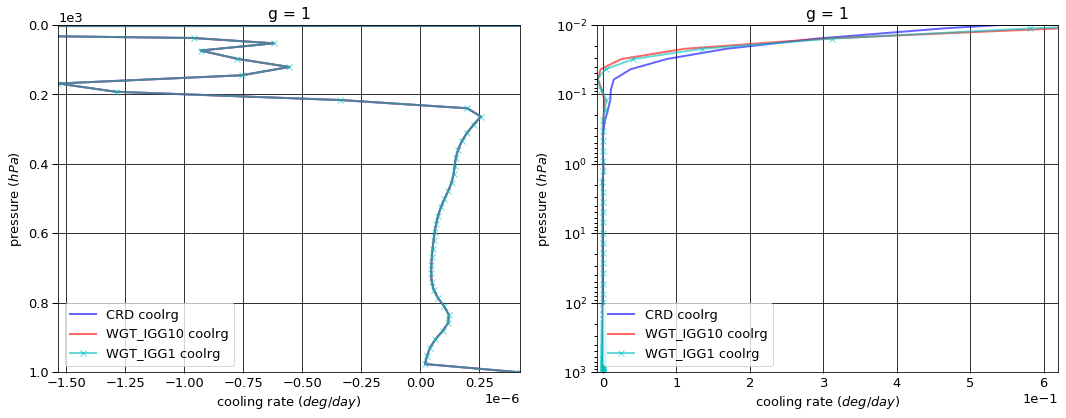

# Figure: cooling rate g-group 2

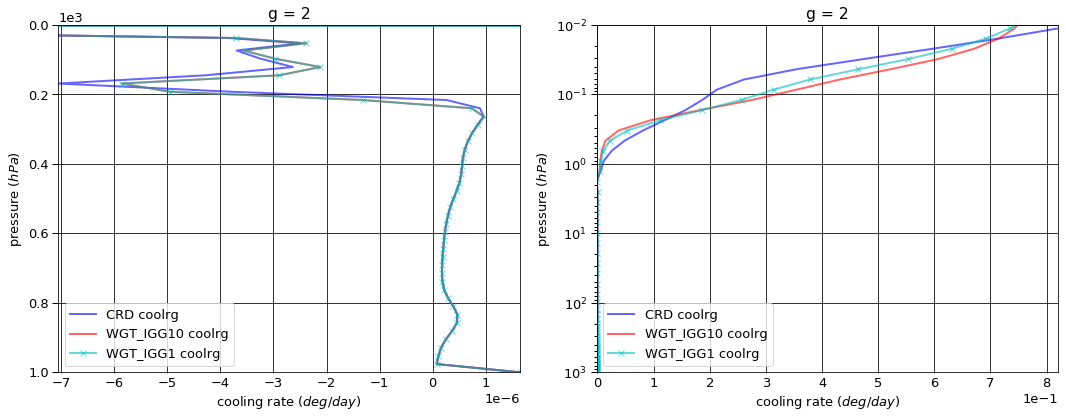

# Figure: cooling rate g-group 3

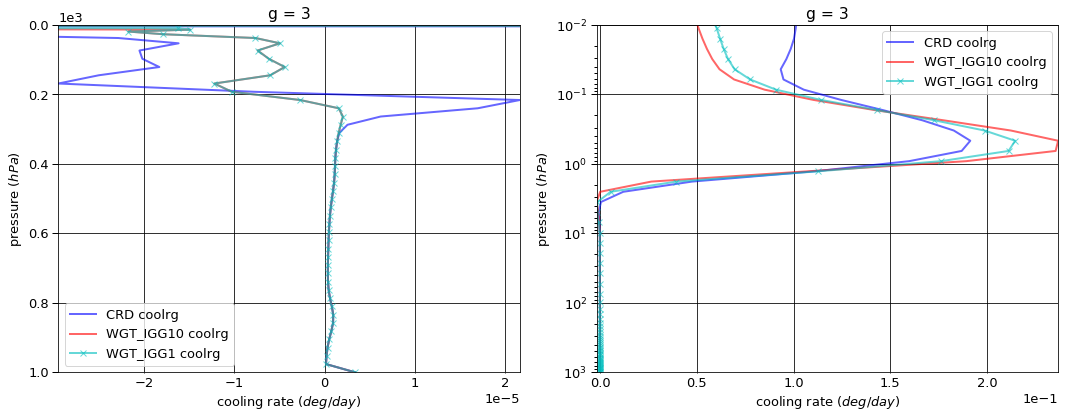

# Figure: cooling rate g-group 4

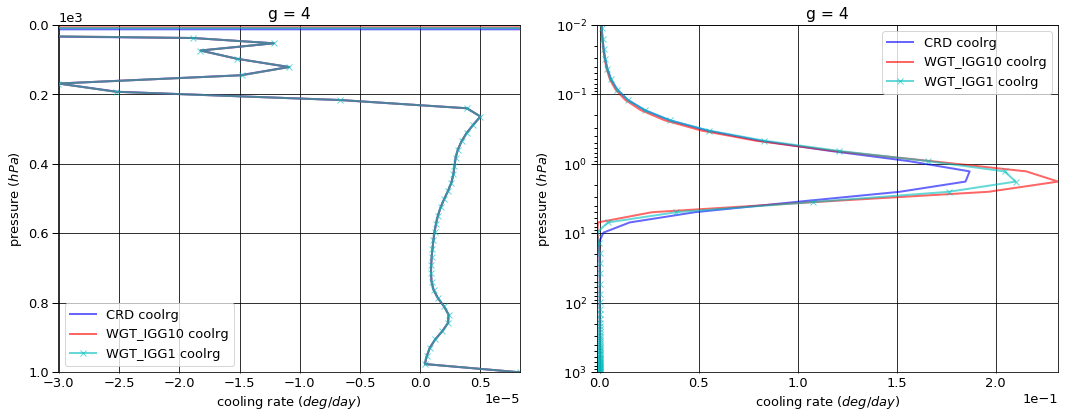

# Figure: cooling rate g-group 5

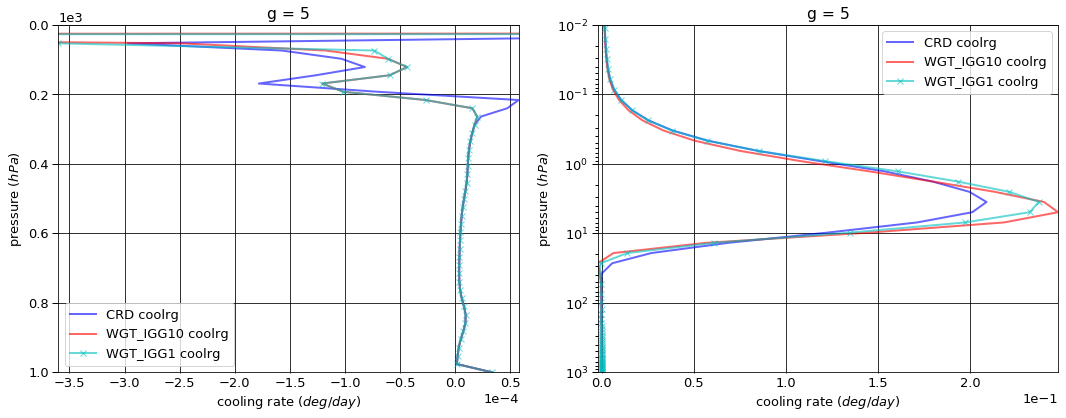

# Figure: cooling rate g-group 6

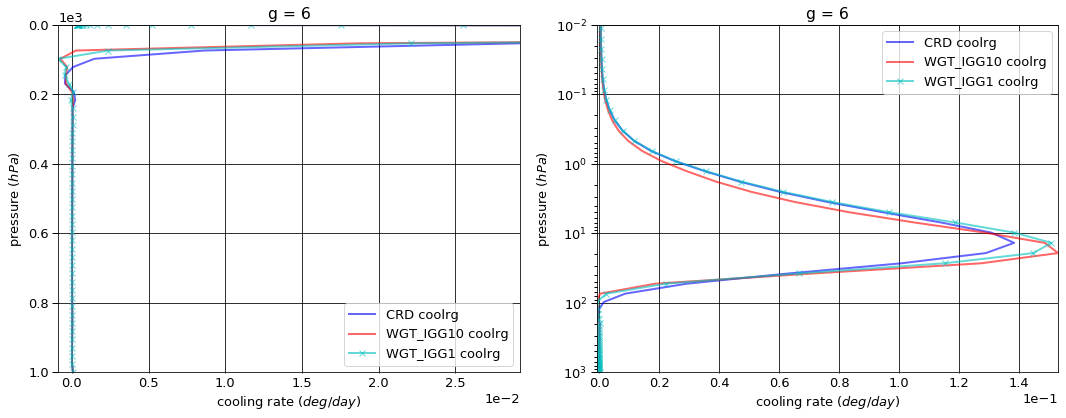

# Figure: cooling rate g-group 7

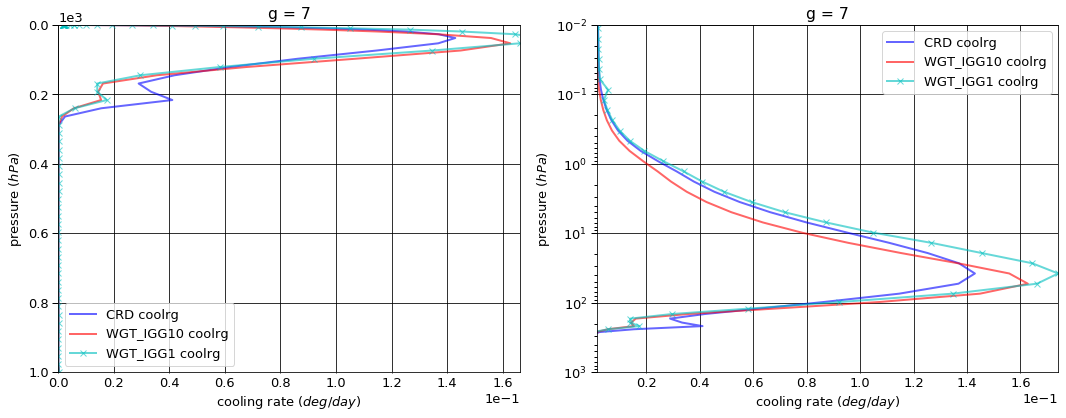

# Figure: cooling rate g-group 8

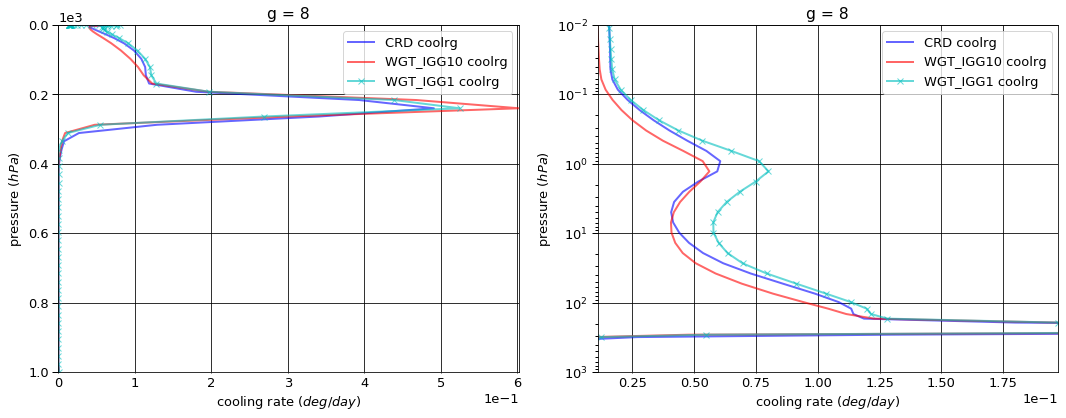

# Figure: cooling rate g-group 9

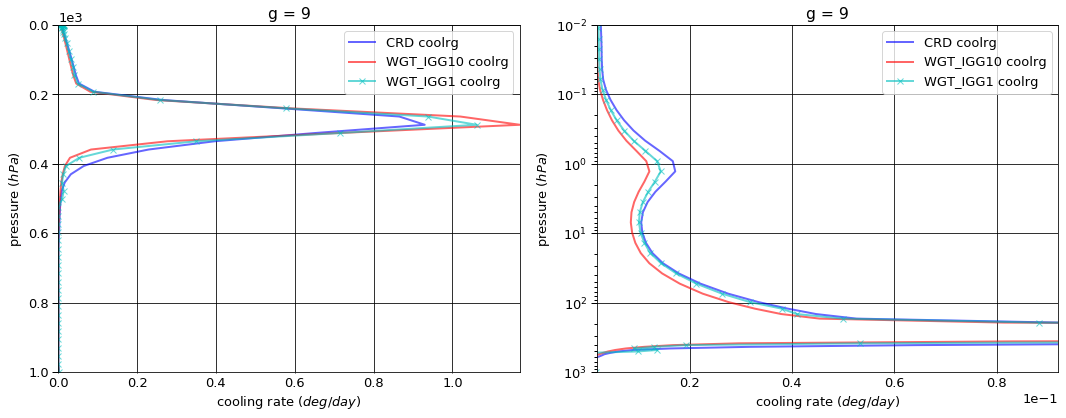

# Figure: cooling rate g-group 10

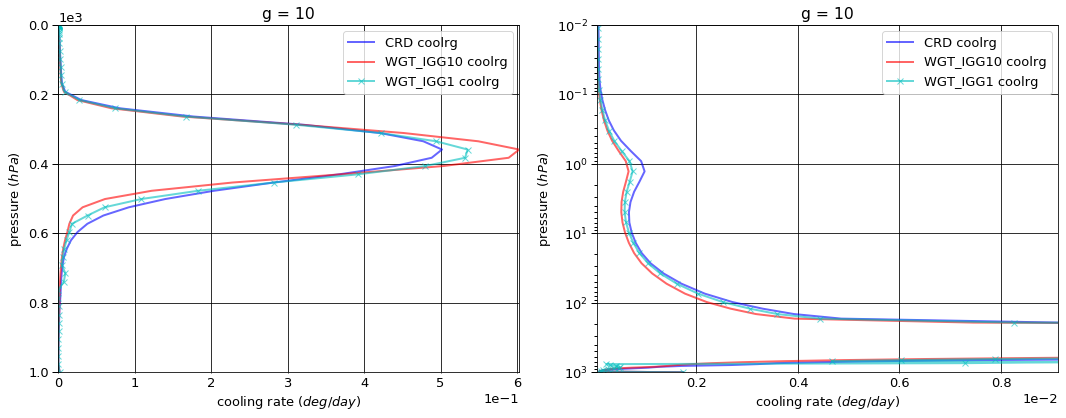

# Figure: cooling rate g-group total

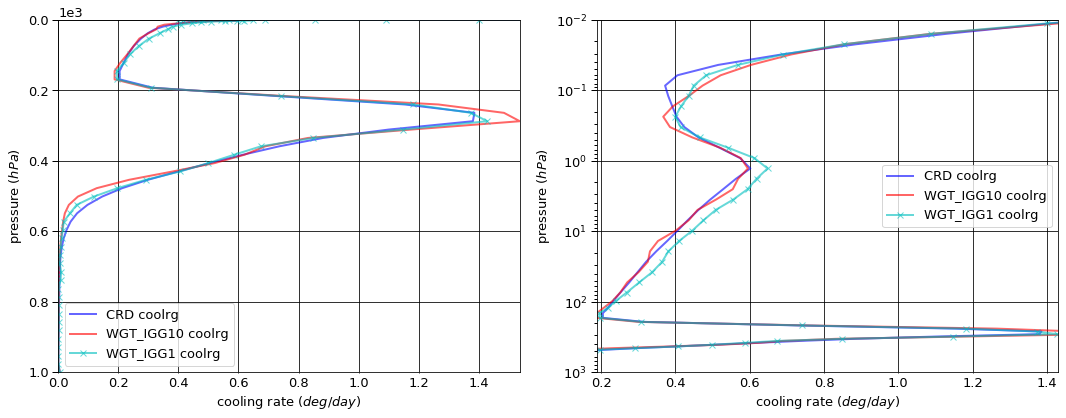

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.002777   0.000000  -0.002777
   1013.0   76     -0.004798   0.004797  -0.000001
2  0.0      1      -0.011183   0.000000  -0.011183
   1013.0   76     -0.017640   0.017636  -0.000005
3  0.0      1      -0.030694   0.000000  -0.030694
   1013.0   76     -0.037953   0.037943  -0.000009
4  0.0      1      -0.076964   0.000000  -0.076964
   1013.0   76     -0.093498   0.093475  -0.000023
5  0.0      1      -0.276238   0.000000  -0.276238
   1013.0   76     -0.374613   0.374520  -0.000092
6  0.0      1      -0.592502   0.000000  -0.592502
   1013.0   76     -0.905934   0.905712  -0.000222
7  0.0      1      -2.103966   0.000000  -2.103966
   1013.0   76     -3.445474   3.444629  -0.000845
8  0.0      1      -6.496473   0.000000  -6.496473
   1013.0   76    -10.362046  10.359491  -0.002554
9  0.0      1     -12.705748   0.000000 -12.705748
   1013.0   76    -18.975218  18.970421  -0.004798
10 0.0      1     -11.936137   0.000000 -11.936137
   1013.0   76    -16.856257  16.851464  -0.004793


WGT_IGG10


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.002758   0.000000  -0.002758
   1013.0   76     -0.004798   0.004797  -0.000001
2  0.0      1      -0.010697   0.000000  -0.010697
   1013.0   76     -0.017640   0.017636  -0.000005
3  0.0      1      -0.030778   0.000000  -0.030778
   1013.0   76     -0.037953   0.037943  -0.000009
4  0.0      1      -0.078273   0.000000  -0.078273
   1013.0   76     -0.093498   0.093475  -0.000023
5  0.0      1      -0.280151   0.000000  -0.280151
   1013.0   76     -0.374613   0.374520  -0.000092
6  0.0      1      -0.594750   0.000000  -0.594750
   1013.0   76     -0.905934   0.905712  -0.000222
7  0.0      1      -2.092315   0.000000  -2.092315
   1013.0   76     -3.445474   3.444629  -0.000845
8  0.0      1      -6.469565   0.000000  -6.469565
   1013.0   76    -10.362046  10.359491  -0.002554
9  0.0      1     -12.598078   0.000000 -12.598078
   1013.0   76    -18.975218  18.970421  -0.004798
10 0.0      1     -11.812675   0.000000 -11.812675
   1013.0   76    -16.856257  16.851475  -0.004781


WGT_IGG1


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.002758   0.000000  -0.002758
   1013.0   76     -0.004798   0.004797  -0.000001
2  0.0      1      -0.010834   0.000000  -0.010834
   1013.0   76     -0.017640   0.017636  -0.000005
3  0.0      1      -0.030816   0.000000  -0.030816
   1013.0   76     -0.037953   0.037943  -0.000009
4  0.0      1      -0.077786   0.000000  -0.077786
   1013.0   76     -0.093498   0.093475  -0.000023
5  0.0      1      -0.279596   0.000000  -0.279596
   1013.0   76     -0.374613   0.374520  -0.000092
6  0.0      1      -0.596347   0.000000  -0.596347
   1013.0   76     -0.905934   0.905712  -0.000222
7  0.0      1      -2.105755   0.000000  -2.105755
   1013.0   76     -3.445474   3.444629  -0.000845
8  0.0      1      -6.447482   0.000000  -6.447482
   1013.0   76    -10.362046  10.359491  -0.002554
9  0.0      1     -12.621025   0.000000 -12.621025
   1013.0   76    -18.975218  18.970421  -0.004798
10 0.0      1     -11.884818   0.000000 -11.884818
   1013.0   76    -16.856257  16.851475  -0.004781


WGT_IGG10 - CRD


flug          fldg         fnetg
g  pressure level                                          
1  0.0      1      1.851340e-05  0.000000e+00  1.851340e-05
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
2  0.0      1      4.866280e-04  0.000000e+00  4.866280e-04
   1013.0   76     0.000000e+00  0.000000e+00 -8.470329e-22
3  0.0      1     -8.361700e-05  0.000000e+00 -8.361700e-05
   1013.0   76     0.000000e+00  0.000000e+00 -1.694066e-21
4  0.0      1     -1.308389e-03  0.000000e+00 -1.308389e-03
   1013.0   76     1.387779e-17  0.000000e+00  0.000000e+00
5  0.0      1     -3.912610e-03  0.000000e+00 -3.912610e-03
   1013.0   76     0.000000e+00  5.551115e-17  0.000000e+00
6  0.0      1     -2.248480e-03  0.000000e+00 -2.248480e-03
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
7  0.0      1      1.165100e-02  0.000000e+00  1.165100e-02
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
8  0.0      1      2.690800e-02  0.000000e+00  2.690800e-02
   1013.0   76     1.776357e-15  0.000000e+00  0.000000e+00
9  0.0      1      1.076700e-01  0.000000e+00  1.076700e-01
   1013.0   76    -3.552714e-15  3.552714e-15 -8.673617e-19
10 0.0      1      1.234620e-01  0.000000e+00  1.234620e-01
   1013.0   76     0.000000e+00  1.100000e-05  1.159800e-05


WGT_IGG1 - CRD


flug          fldg         fnetg
g  pressure level                                          
1  0.0      1      1.886940e-05  0.000000e+00  1.886940e-05
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
2  0.0      1      3.487160e-04  0.000000e+00  3.487160e-04
   1013.0   76     0.000000e+00  0.000000e+00 -8.470329e-22
3  0.0      1     -1.221810e-04  0.000000e+00 -1.221810e-04
   1013.0   76     0.000000e+00  0.000000e+00 -1.694066e-21
4  0.0      1     -8.212090e-04  0.000000e+00 -8.212090e-04
   1013.0   76     1.387779e-17  0.000000e+00  0.000000e+00
5  0.0      1     -3.357550e-03  0.000000e+00 -3.357550e-03
   1013.0   76     0.000000e+00  5.551115e-17  0.000000e+00
6  0.0      1     -3.844830e-03  0.000000e+00 -3.844830e-03
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
7  0.0      1     -1.789000e-03  0.000000e+00 -1.789000e-03
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
8  0.0      1      4.899100e-02  0.000000e+00  4.899100e-02
   1013.0   76     1.776357e-15  0.000000e+00  0.000000e+00
9  0.0      1      8.472300e-02  0.000000e+00  8.472300e-02
   1013.0   76    -3.552714e-15  3.552714e-15 -8.673617e-19
10 0.0      1      5.131900e-02  0.000000e+00  5.131900e-02
   1013.0   76     0.000000e+00  1.100000e-05  1.159800e-05

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1      5.211350e+00
   1001.112500 75     4.215479e-07
2  0.000312    1      1.219167e+00
   1001.112500 75     1.642620e-06
3  0.000312    1      9.355681e-02
   1001.112500 75     3.374864e-06
4  0.000312    1      6.765906e-05
   1001.112500 75     8.270525e-06
5  0.000312    1      9.025177e-04
   1001.112500 75     3.332748e-05
6  0.000312    1      3.142795e-04
   1001.112500 75     8.013777e-05
7  0.000312    1      1.652537e-03
   1001.112500 75     3.057159e-04
8  0.000312    1      1.348389e-02
   1001.112500 75     9.237765e-04
9  0.000312    1      2.281942e-03
   1001.112500 75     1.735009e-03
10 0.000312    1      5.614973e-05
   1001.112500 75     1.733303e-03


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1      3.496595e+00
   1001.112500 75     4.215479e-07
2  0.000312    1      7.339544e-01
   1001.112500 75     1.642620e-06
3  0.000312    1      4.001213e-02
   1001.112500 75     3.374864e-06
4  0.000312    1      5.135418e-05
   1001.112500 75     8.270525e-06
5  0.000312    1      8.964475e-04
   1001.112500 75     3.332748e-05
6  0.000312    1      2.680262e-04
   1001.112500 75     8.013777e-05
7  0.000312    1      1.210335e-03
   1001.112500 75     3.057159e-04
8  0.000312    1      9.449521e-03
   1001.112500 75     9.237765e-04
9  0.000312    1      1.559008e-03
   1001.112500 75     1.735009e-03
10 0.000312    1      3.541773e-05
   1001.112500 75     1.728557e-03


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1      4.065712e+00
   1001.112500 75     4.215479e-07
2  0.000312    1      8.191277e-01
   1001.112500 75     1.642620e-06
3  0.000312    1      4.848670e-02
   1001.112500 75     3.374864e-06
4  0.000312    1      5.706260e-05
   1001.112500 75     8.270525e-06
5  0.000312    1      9.942774e-04
   1001.112500 75     3.332748e-05
6  0.000312    1      3.188706e-04
   1001.112500 75     8.013777e-05
7  0.000312    1      1.665454e-03
   1001.112500 75     3.057159e-04
8  0.000312    1      1.356976e-02
   1001.112500 75     9.237765e-04
9  0.000312    1      1.875230e-03
   1001.112500 75     1.735009e-03
10 0.000312    1      4.102609e-05
   1001.112500 75     1.728557e-03


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -1.714755e+00
   1001.112500 75     0.000000e+00
2  0.000312    1     -4.852124e-01
   1001.112500 75    -2.117582e-22
3  0.000312    1     -5.354468e-02
   1001.112500 75     0.000000e+00
4  0.000312    1     -1.630488e-05
   1001.112500 75     0.000000e+00
5  0.000312    1     -6.070240e-06
   1001.112500 75     0.000000e+00
6  0.000312    1     -4.625336e-05
   1001.112500 75     0.000000e+00
7  0.000312    1     -4.422021e-04
   1001.112500 75     0.000000e+00
8  0.000312    1     -4.034368e-03
   1001.112500 75     0.000000e+00
9  0.000312    1     -7.229341e-04
   1001.112500 75     0.000000e+00
10 0.000312    1     -2.073200e-05
   1001.112500 75    -4.746400e-06


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -1.145638e+00
   1001.112500 75     0.000000e+00
2  0.000312    1     -4.000391e-01
   1001.112500 75    -2.117582e-22
3  0.000312    1     -4.507011e-02
   1001.112500 75     0.000000e+00
4  0.000312    1     -1.059646e-05
   1001.112500 75     0.000000e+00
5  0.000312    1      9.175971e-05
   1001.112500 75     0.000000e+00
6  0.000312    1      4.591110e-06
   1001.112500 75     0.000000e+00
7  0.000312    1      1.291730e-05
   1001.112500 75     0.000000e+00
8  0.000312    1      8.586900e-05
   1001.112500 75     0.000000e+00
9  0.000312    1     -4.067120e-04
   1001.112500 75     0.000000e+00
10 0.000312    1     -1.512364e-05
   1001.112500 75    -4.746400e-06

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.232682,0.000000,-34.232682
1013.0,76,-51.073429,51.060087,-0.013342



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-33.970039,0.000000,-33.970039
1013.0,76,-51.073429,51.060098,-0.013331



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.057217,0.000000,-34.057217
1013.0,76,-51.073429,51.060098,-0.013331



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.262643,0.000000,0.262643
1013.0,76,0.000000,0.000011,0.000012



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.175466,0.000000,0.175466
1013.0,76,0.000000,0.000011,0.000012


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,6.542833
1001.112500,75,0.004825



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,4.284032
1001.112500,75,0.004820



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,4.951848
1001.112500,75,0.004820



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.258801
1001.112500,75,-0.000005



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-1.590985
1001.112500,75,-0.000005


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000109,0.000096
2,0.000341,0.000347
3,0.000884,0.000756
4,0.002078,0.001866
5,0.008837,0.007466
6,0.020303,0.018082
7,0.082453,0.068733
8,0.239828,0.206380
9,0.400194,0.375109


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,3.441550e-16
2,3.621082e-17
3,3.809979e-18
4,9.034937e-18
5,9.970460e-19
6,9.178721e-19
7,1.059911e-19
8,1.223930e-20
9,1.413330e-21


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,3.441550e-16,NaN,0.000109,0.000096,0.000109,0.000096,1.0
2,3.621082e-17,0.105217,0.000341,0.000347,0.000450,0.000443,1.0
3,3.809979e-18,0.105217,0.000884,0.000756,0.001334,0.001199,1.0
4,9.034937e-18,2.371387,0.002078,0.001866,0.003413,0.003065,30.0
5,9.970460e-19,0.110355,0.008837,0.007466,0.012250,0.010531,30.0
6,9.178721e-19,0.920592,0.020303,0.018082,0.032553,0.028613,300.0
7,1.059911e-19,0.115475,0.082453,0.068733,0.115006,0.097346,300.0
8,1.223930e-20,0.115475,0.239828,0.206380,0.354834,0.303726,300.0
9,1.413330e-21,0.115475,0.400194,0.375109,0.755028,0.678835,300.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [27]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g  pressure                                                        
1     1  0.000312     1.176304e-15  4.871858e-16   2.414489  6.496376e-02
      2  0.000312     6.197648e-17  2.973686e-17   2.084163  3.630650e-03
      3  0.000312     2.604102e-18  1.060612e-18   2.455283  1.429011e-04
      4  0.000312     9.604734e-22  9.354148e-22   1.026789  8.051460e-08
      5  0.000312     3.839127e-21  3.006672e-21   1.276869  2.844088e-07
      6  0.000312     4.155597e-22  3.034438e-22   1.369479  2.966079e-08
      7  0.000312     5.604240e-22  1.202065e-22   4.662177  3.647952e-08
      8  0.000312     1.634953e-21  5.132597e-23  31.854304  9.877543e-08
      9  0.000312     1.375790e-22  5.082506e-24  27.069131  8.331321e-09
      10 0.000312     4.651030e-24  3.806331e-25  12.219195  2.869855e-10
2     1  0.000750     1.176019e-15  4.879079e-16   2.410330  2.617748e-02
      2  0.000750     6.216800e-17  2.983304e-17   2.083864  1.466985e-03
      3  0.000750     2.617084e-18  1.067799e-18   2.450914  5.788469e-05
      4  0.000750     1.467824e-21  1.442576e-21   1.017502  4.982932e-08
      5  0.000750     3.931631e-21  3.087544e-21   1.273385  1.174897e-07
      6  0.000750     4.212920e-22  3.089352e-22   1.363691  1.213864e-08
      7  0.000750     5.625799e-22  1.212642e-22   4.639290  1.475612e-08
      8  0.000750     1.639092e-21  5.156669e-23  31.785856  3.988727e-08
      9  0.000750     1.380260e-22  5.108353e-24  27.019677  3.366744e-09
      10 0.000750     4.671273e-24  3.827681e-25  12.203925  1.161020e-10
3     1  0.001052     1.175594e-15  4.892744e-16   2.402729  3.674218e-02
      2  0.001052     6.255064e-17  3.000047e-17   2.084989  2.069474e-03
      3  0.001052     2.640123e-18  1.077219e-18   2.450869  8.189186e-05
      4  0.001052     1.821709e-21  1.796448e-21   1.014061  8.690296e-08
      5  0.001052     4.043228e-21  3.174766e-21   1.273551  1.694307e-07
      6  0.001052     4.262464e-22  3.133528e-22   1.360276  1.724589e-08
      7  0.001052     5.660212e-22  1.223396e-22   4.626639  2.082516e-08
      8  0.001052     1.647824e-21  5.187245e-23  31.766843  5.623580e-08
      9  0.001052     1.389692e-22  5.144476e-24  27.013282  4.753753e-09
      10 0.001052     4.713213e-24  3.859499e-25  12.211981  1.642779e-10
4     1  0.001476     1.175111e-15  4.907436e-16   2.394553  5.159178e-02
      2  0.001476     6.296064e-17  3.018392e-17   2.085900  2.921744e-03
      3  0.001476     2.665492e-18  1.088169e-18   2.449520  1.160136e-04
      4  0.001476     2.316295e-21  2.291007e-21   1.011038  1.552916e-07
      5  0.001476     4.177093e-21  3.281805e-21   1.272803  2.456406e-07
      6  0.001476     4.326982e-22  3.192344e-22   1.355425  2.460644e-08
      7  0.001476     5.698990e-22  1.236758e-22   4.608009  2.942569e-08
      8  0.001476     1.657204e-21  5.223053e-23  31.728639  7.934310e-08
      9  0.001476     1.399813e-22  5.185879e-24  26.992788  6.717655e-09
      10 0.001476     4.758648e-24  3.895546e-25  12.215613  2.326835e-10
5     1  0.002070     1.174578e-15  4.922531e-16   2.386126  7.242748e-02
      2  0.002070     6.337845e-17  3.037760e-17   2.086355  4.124817e-03
      3  0.002070     2.692359e-18  1.100721e-18   2.445997  1.644493e-04
      4  0.002070     3.007736e-21  2.982386e-21   1.008500  2.832540e-07
      5  0.002070     4.336031e-21  3.412702e-21   1.270556  3.579839e-07
      6  0.002070     4.411279e-22  3.270931e-22   1.348631  3.527814e-08
      7  0.002070     5.741410e-22  1.253361e-22   4.580810  4.160031e-08
      8  0.002070     1.666746e-21  5.264480e-23  31.660212  1.119296e-07
      9  0.002070     1.410101e-22  5.232439e-24  26.949217  9.491583e-09
      10 0.002070     4.805365e-24  3.935452e-25  12.210452  3.295674e-10
6     1  0.002904     1.173974e-15  4.938184e-16   2.377340  1.016894e-01
      2  0.002904     6.380626e-17  3.058527e-17   2.086177  5.825302e-03
      3  0.002904     2.721213e

# Histogram of wavenumbers in g-group 1

In [28]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [29]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
